# 미니프로젝트 : 뉴스 기사 Text Summarization 

텍스트 요약(Text Summarization)이란 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것이다.

텍스트 요약은 크게 추출적 요약(extractive summarization)과 추상적 요약(abstractive summarization)으로 나뉜다.

- __추출적 요약(Extractive Summarization)__ : 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법
- __추상적 요약(Abstractive Summarization)__ : 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법

두 가지 방법을 각각 이용하여 뉴스기사 데이터셋을 요약해보자.

----

----
# 추상적 요약 (Abstractive Summarization)


## 0. 필요한 모듈 불러오기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. 데이터 준비
아래 링크에 있는 뉴스 기사 데이터(`news_summary_more.csv`) 를 사용한다.
>[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
95351,UP man kills daughter & her boyfriend for 'fam...,A man murdered his 19-year-old daughter and he...
24824,Ex-delivery boy partners Amazon employee to ch...,Amazon India's ex-delivery boy partnered with ...
29619,Kerala asks visitors to avoid 4 districts amid...,After 12 people died due to Nipah virus in Ker...
94258,Barclays CEO faces pay cut on trying to unmask...,Banking major Barclays' CEO Jes Staley will be...
68935,PV Sindhu becomes world number 2 in latest ran...,Rio Olympic silver medalist PV Sindhu has jump...
30930,Aditya Birla Capital's 2 firms seek approval f...,Aditya Birla Capital's two units are in the pr...
95356,Hugh Jackman saved me from burning building on...,Actor Zac Efron has revealed he was saved from...
33763,13-year-old boy signed by professional gaming ...,Thirteen-year-old Kyle Jackson has become one ...
49175,Aus to use Tesla batteries for 'largest virtua...,South Australia is planning to use Tesla batte...
97764,We fight everywhere: Kapil on reports of assau...,Reacting to reports of him physically assaulti...


이 데이터는 기사의 본문에 해당되는 `text`와 `headlines` 두 가지 열로 구성되어 있다.  

각 요약 방법에 따라 데이터를 아래와 같이 사용한다.
- 추상적 요약 :  text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습
- 추출적 요약 : 오직 text열만을 사용 

----
## 2. 데이터 전처리

데이터 전처리 과정은 크게 세 과정으로 나눠서 진행한다.  

- 데이터 정리
- 훈련 데이터와 데스트 데이터 분할
- 정수 인코딩

## 2-1 .  데이터 전처리 - 데이터 정리

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
# 데이터의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280



Headlines 는 아주 간단한 요약들도 많아서 Text가 달라도 headlines는 동일할 수 있다. 따라서 Text 자체가 중복이 된 경우만 중복 샘플로 취급하여 제거한다.

전체 샘플수는 98401개 이므로 `text` 열에서 41개 중복이 존재하는 것을 알 수 있다.

In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


`.isnull().sum()` 를 사용해 데이터의 Null 값이 있는지 확인한다.

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


결측치가 존재하지 않는 것을 확인 할 수 있다.

### 텍스트 정규화와 불용어 제거

__텍스트 정규화(text normalization)__ 란, `it'll` = `it will`, `mustn't` = `must not` 와 같은 같은 의미의 표현들을 통일시키는 과정이다. 텍스트 정규화를 통해 기계의 연산량을 줄일 수 있다.  

아래의 링크를 참고하여 텍스트 정규화를 위한 딕셔너리를 구성한다.  
> [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


__불용어__ 란 자연어 처리를 할 때 의미를 분석하고 요약하는 데는 거의 의미가 없는 단어이다.

`NLTK` 에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다.

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

다음과 같은 기능을 수행하는 데이터 전처리 함수 `preprocess_sentence` 를 생성한다.

- 모든 영어 문자를 소문자로 변환
- 섞여있는 html 태그 제러
- 정규 표현식을 통해 각종 특수문자 제거
- `text` 데이터만 불용어 제거하기 위해 함수의 인자로 remove_stopwords 추가 -> Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 `headlines`에는 남아 있는 게 더 좋음

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

훈련 데이터 전체에 대해서 전처리를 수행한다.

`text`의 경우에는 불용어를 제거하고, `headlines` 의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행한다.

멀티프로세싱을 활용하여 별도의 프로세스를 생성하여 병렬처리로 소요시간을 단축하여 진행한다.

In [10]:
import multiprocessing as mp  
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 함

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_headlines)

183.60071063041687  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있디. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

데이터를 보다 쉽게 확인하기 위하여 데이터프레임에 저장한다. 이후 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [11]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

## 2-2. 데이터 전처리 - 훈련 데이터와 테스트 데이터 분할

### 샘플의 최대 길이 정하기
`text` 와 `headlines` 의 최소, 최대, 평균 길이를 구하도 길이 분포를 시각화해보자.

text 의 최소 길이 : 1
text 의 최대 길이 : 60
text 의 평균 길이 : 35.09968483123221
headlines 의 최소 길이 : 1
headlines 의 최대 길이 : 16
headlines 의 평균 길이 : 9.299532330215534


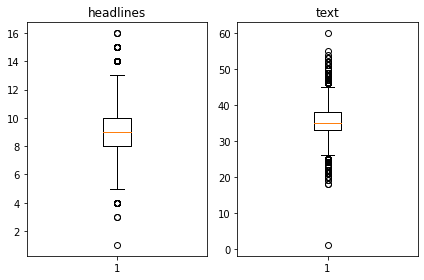

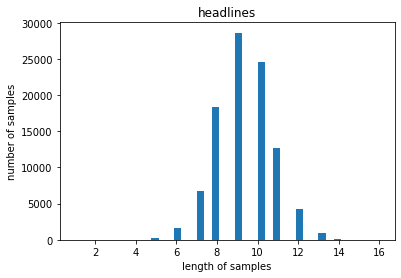

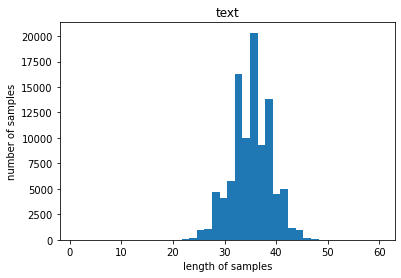

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text 의 최소 길이 : {}'.format(np.min(text_len)))
print('text 의 최대 길이 : {}'.format(np.max(text_len)))
print('text 의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서부터 그래프의 의미는 차례대로 아래과 같다.

- Summary 과 실제 Text 의 길이 분포
- 요약본 샘플 길이별 개수
- 실제 텍스트 샘플 길이별 개수

`text` 와 `headlines` 모두 정규 분포 곡선과 비슷한 형태로 데이터가 분포하는 것을 알 수 있다. 따라서 `text` 와 `headlines` 의 최대 길이는 모든 데이터가 포함 될수 있도록 지정한다.

In [13]:
text_max_len = 60
headlines_max_len = 16

In [14]:
def below_threshold_len(max_len, nested_list):  # 데이터의 몇 %가 해당하는지 계산하는 함수
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


### 시작 토근과 종료 토근 추가

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가해야한다.

시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 임의로 명명하고 앞, 뒤로 추가한다.

In [15]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [16]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장 

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터 분할

`sklearn.model_selection` 의 `train_test_split` 을 사용해 훈련 데이터와 테스트 데이터를 분할한다.  

이때 `test_size` 값은 `0.2`로 지정한다. 또한 결과를 일정하게 보여주기 위하여 `random_state` 값은 `34`로 지정한다.

In [17]:
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input,
                                                                                                                                               decoder_input,
                                                                                                                                               decoder_target,
                                                                                                                                               test_size=0.2,                                   
                                                                                                                                               random_state=34)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 2-3. 데이터 전처리 - 정수 인코딩
### 단어 집합(vocabulary) 만들기 및 정수 인코딩

Keras의 토크나이저를 사용해서 입력된 훈련 데이터로부터 단어 집합을 만들자.

In [18]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 `src_tokenizer.word_index` 에 저장되어 있다.

만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외한다.

`src_tokenizer.word_counts.items()` 를 사용하여 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [19]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69618
등장 빈도가 7번 이하인 희귀 단어의 수: 48939
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20679
단어 집합에서 희귀 단어의 비율: 70.29647504955615
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.856952677557366


- 등장 빈도가 threshold 값인 8회 미만, 즉, 7회 이하인 단어들은 단어 집합에서 무려 70% 를 차지함.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.8%밖에 되지 않음.

그래서 등장 빈도가 7회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.

위에서 이를 제외한 단어 집합의 크기를 2만여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한한다.

In [20]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [21]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[1833, 919, 237, 1, 339, 9681, 1037, 3044, 231, 11884, 9152, 2916, 4000, 856, 4467, 200, 1515, 7671, 6477, 1085, 6, 4, 919, 1, 11573, 14794, 9488, 559, 431, 861]


### headlines 데이터에 대해서도 동일한 작업 수행

In [22]:
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [23]:
# 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30026
등장 빈도가 6번 이하인 희귀 단어의 수: 20509
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9517
단어 집합에서 희귀 단어의 비율: 68.30413641510691
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.292321359169396


In [24]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[0])
print('target')
print('decoder ',decoder_target_train[0])

input
input  [1, 142, 10, 636, 8784, 16, 1481, 522, 526]
target
decoder  [142, 10, 636, 8784, 16, 1481, 522, 526, 2]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

`decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이므로 길이가 0이 된 요악문의 실제 길이는 1로 나올 것이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장하고 샘플들은 모두 삭제한다.

In [25]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩 추가

최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 아까 정해두었던 최대 길이로 길이를 맞춘다.

In [26]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

----
## 3. 모델 설계

### seq2seq

In [27]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [28]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [29]:
# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘

In [30]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [31]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

----
## 4. 모델 훈련

In [32]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 293s 913ms/step - loss: 4.6212 - val_loss: 3.8606
Epoch 2/50
308/308 [==============================] - 282s 915ms/step - loss: 3.8204 - val_loss: 3.6037
Epoch 3/50
308/308 [==============================] - 281s 912ms/step - loss: 3.5437 - val_loss: 3.3962
Epoch 4/50
308/308 [==============================] - 279s 905ms/step - loss: 3.3162 - val_loss: 3.2476
Epoch 5/50
308/308 [==============================] - 276s 898ms/step - loss: 3.1540 - val_loss: 3.1354
Epoch 6/50
308/308 [==============================] - 272s 882ms/step - loss: 3.0223 - val_loss: 3.0431
Epoch 7/50
308/308 [==============================] - 271s 880ms/step - loss: 2.9090 - val_loss: 2.9781
Epoch 8/50
308/308 [==============================] - 271s 879ms/step - loss: 2.8074 - val_loss: 2.9267
Epoch 9/50
308/308 [==============================] - 271s 881ms/step - loss: 2.7146 - val_loss: 2.8760
Epoch 10/50
308/308 [==============================] - 272s 882m

조기 종료'를 뜻하는 EarlyStopping 은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.

위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정했다.

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 하였다.

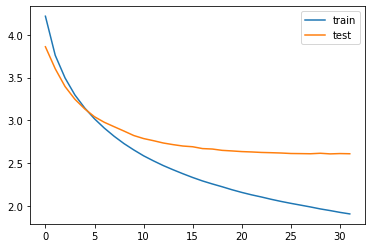

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

----
## 5. 인퍼런스 모델 구현

In [34]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [35]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [36]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만든다.

In [37]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

----
## 6. 모델 테스트

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다.

이때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [38]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [39]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former indian navy officer kulbhushan jadhav mother called ki maa pakistan media outside country foreign office islamabad meeting son monday jadhav mother wife forced wait car heckled journalists jadhav sentenced death pakistan military court 
실제 요약 : pakistan media calls jadhav mother ki maa 
예측 요약 :  jadhav son to meet pak mother in jadhav case


원문 : second odi india windies visakhapatnam wednesday ended last ball tie teams scored runs india second tied odi month tie afghanistan september tie india extended unbeaten run across formats international cricket matches 
실제 요약 : nd india wi odi ends in tie india nd tied odi in month 
예측 요약 :  india lose to odi series vs india in last years


원문 : india anti doping body national anti doping agency reportedly conducted tests intended target tests throughout tests conducted april december notably india ranked third global anti doping violation figures 
실제 요약 : conducted tests out of target of 
예측 요약 :  india doping violations suspended 

예측 요약 :  player arrested for throwing player shot at player in match


원문 : ipl chairman rajeev shukla said consider kolkata knight riders owner shah rukh khan suggestion reserve day ipl playoffs kkr rain hit win sunrisers hyderabad eliminator wednesday shah rukh tweeted playoffs needed alternative day case abandoned match kkr got six overs play eliminator 
실제 요약 : ipl chairman considers srk for ipl playoffs 
예측 요약 :  shah rukh khan to be sad on ipl auction reports


원문 : many police personnel awarded medals eve republic day president ram nath kovind awarded police medals gallantry three personnel decorated president police medal gallantry award crpf decorated maximum followed odisha police received medals 
실제 요약 : police officers awarded medals on eve of republic day 
예측 요약 :  police national award to be held at rally


원문 : bjp president amit shah wednesday said person associated bjp found involved destroying statue face severe action party adding bjp support bringing anybody statue 

예측 요약 :  virat anushka zaheer sagarika zaheer zaheer on marriage


원문 : passenger reportedly found insect pakoda served staff bihar kranti express fellow passenger tweeted picture meal following railway ministry directed officials look matter urgently several passengers also eaten pakodas reportedly developed vomiting incident 
실제 요약 : insect found in pakoda served in express 
예측 요약 :  passenger found in bihar hotel after his dogs


원문 : anurag kashyap friday took twitter wrote shook hands mike tyson mumbai airport believe india tyson mumbai airport early friday morning india inaugurate league national sports club india mumbai tyson maiden india visit 
실제 요약 : hands with mike tyson cannot believe it anurag 
예측 요약 :  anurag kashyap trolls air india over rail rail flight


원문 : actor known cameo appearance rajkumar hirani raho munna bhai passed away due lung ailment residence dadar mumbai monday suffering lung infection past one half years actor also known contribution marathi theatre 
실

어느정도 요약된 문장이 출력되는 것을 확인 할 수 있다.

----
----
# 추출적 요약 (Extractive Summarization)
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 구현할 수 있다.

In [40]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [41]:
data.sample(10)

,headlines,text
96503,Smith takes one-handed catch to dismiss Wriddh...,Australian captain Steve Smith took a one-hand...
34901,Chandrayaan-2 to cost Ã¢ÂÂ¹800 crore: ISRO Ch...,"India's second Moon mission, the Chandrayaan-2..."
46767,IAF officer becomes 1st Indian woman to fly fi...,Indian Air Force officer Avani Chaturvedi has ...
7218,US rapper 2 Milly sues Fortnite maker for stea...,US rapper 2 Milly has sued Epic Games saying t...
9556,"Ball slips out of SA fast bowler's hand, lands...",During the ninth over of Australia's innings i...
19223,Researcher admits plot to steal GSK secrets to...,A US cancer researcher has pleaded guilty to c...
17113,Rishabh Pant's coach recommended for Dronachar...,"Delhi's Tarak Sinha, coach of wicketkeeper-bat..."
48339,UP CM calls for simpler exams as 10 lakh skip ...,After around 10 lakh students skipped Board ex...
35915,"Told govt note ban wasn't well-planned, useful...",Former RBI Governor Raghuram Rajan has reveale...
88836,1st reaction was 'I've to play Sanjay's mother...,"Actress Manisha Koirala, while talking about b..."


### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [42]:
# 데이터의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [43]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [44]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### summarize 를 사용한 추출적 요약

In [45]:
data['headlines_predict'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [46]:
data.sample(10)

,headlines,text,headlines_predict
31476,BJP K'taka candidate performs gau puja before ...,BJP candidate B Sriramulu performed gau puja b...,He is contesting from the Badami seat against ...
22194,India invite to Trump not exclusive to Republi...,India's invitation to US President Donald Trum...,This comes after White House officials reveale...
68277,PM Modi should apologise over BHU incident: Ra...,Congress Vice President Rahul Gandhi on Tuesda...,Congress Vice President Rahul Gandhi on Tuesda...
43436,Cops in Haryana violating 'lal batti' norms: T...,The Indian Police Service officers in Haryana ...,The Indian Police Service officers in Haryana ...
3234,GST panel approves Kerala levying 1% calamity ...,A ministerial panel on Sunday allowed flood-hi...,A ministerial panel on Sunday allowed flood-hi...
43618,India not really prepared for electric vehicle...,Volkswagen India President and MD Andreas Laue...,Volkswagen India President and MD Andreas Laue...
71721,GST Council may lower tax rates if high collec...,GST Council may consider lowering tax on items...,GST Council may consider lowering tax on items...
93382,US successfully tests new nuclear gravity bomb,The US National Nuclear Security Administratio...,The US National Nuclear Security Administratio...
49285,"BCCI website expires, down even during India-S...","BCCI's official domain, bcci.tv, reportedly ex...","BCCI has yet not renewed the domain, which is ..."
75961,Women to carry out 'Bekhauf Aazaadi March' in ...,"In light of Varnika Kundu stalking case, 'Bekh...",The organisers of the event said that they are...


In [47]:
for i in range(50, 100):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("예측 요약 :", data['headlines_predict'][i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

----
# 프로젝트 정리

### 추상적 요약
__원문__ :  
us indian space agencies nasa isro jointly develop launch world biggest expensive earth imaging satellite costing billion satellite named nisar nasa isro synthetic radar satellite take earth every week helping scientists study changes climate environment 
   
   
__실제 요약__ : nasa isro to jointly make most expensive satellite 


__예측 요약__ : spacex to launch nasa mars for mars mission report

위의 예측 결과를 보면, 추상적 요약에서는 키워드를 찾아내고 그것을 요약할 수 있는 새로운 단어를 만들어 요약을 하는 모습을 확인 할 수 있다. 하지만 위와 같이 아주 대략적인 범주는 비슷하지만 구체적으로 보면 원문의 내용과는 연관성이 떨어지는 요약을 하는 경우도 다수 확인 할 수 있다.
  
  


### 추출적 요약
__원문__ :  
Prime Minister Narendra Modi stopped his speech at the inauguration of the new terminal building at Surat airport after observing that a cameraman had fainted. PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman. "It's good that PM was paying attention to his surroundings during his speech," the cameraman later said from a hospital. 
   
   
__실제 요약__ : PM Modi stops speech after cameraman faints, asks officers to help  


__예측 요약__ : PM Modi then asked his officers to urgently arrange for an ambulance for the cameraman.

위의 예측 결과를 보면, 추출적 요약에서는 어느정도 연관성과 일관성을 가지고 요약이 된 것을 확인 할 수 있다. 하지만 then 같은 문장의 중간 순서를 표시하는 단어를 포함하고 있어 뉴스의 헤드라인에는 어색한 느낌을 주기도 하였다.

결론적으로, 대중들에게 정보를 정확하게 전달해야하는 뉴스의 특성상, 실제 원문과 관련성이 없는 요약이 다수 존재하는 추상적 요약 모델의 경우보다, 일부 내용이 빠져있더라도 전체적인 내용을 포괄할 수 있는 추출적 요약 모델이 더 적합 할 것이라고 생각된다. 